In [3]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
from scipy.spatial.distance import pdist, squareform
import pylab as pl
import json
import geopandas as gp
import pandas as pd
import numpy as np
import os

PUIdata = os.getenv('PUIDATA')

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [4]:
pl.rcParams.update({'axes.facecolor':'#ffffff', 
                    'grid.color': u'#bcbcbc',
                    'xtick.labelsize': 15,
                    'ytick.labelsize': 15})
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = '''
SELECT 
COUNT(*) as count,
zipcodes
FROM nycasthmasdismissals
GROUP BY zipcodes'''

facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities.columns = ['count', 'ZIPCODE']
facilities.ZIPCODE = facilities.ZIPCODE.astype(str)
facilities.head()

,count,ZIPCODE
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


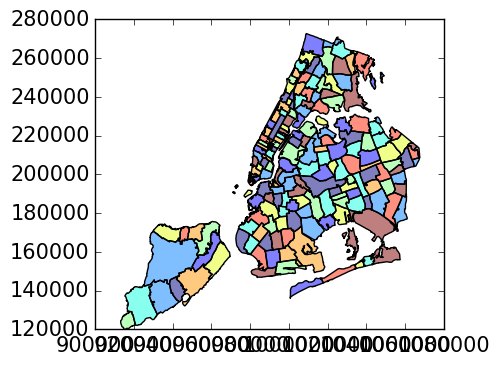

In [6]:
#read in NYC zipcode shapefile
nycshp = gp.read_file(PUIdata + '/ZIP_CODE_040114.shp')
nycshp.plot()

In [7]:
nycshp.ZIPCODE = nycshp.ZIPCODE.astype(str)
nycshp = nycshp[["ZIPCODE", "geometry"]]
nycshp['centers'] = nycshp['geometry'].centroid
nycshp.head()

,ZIPCODE,geometry,centers
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",POINT (1040696.262135346 185580.2219140405)
1,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",POINT (1001912.871996466 183803.1131420481)
2,11212,"POLYGON ((1011174.275535807 183696.33770971, 1...",POINT (1008365.375095716 180768.9448568909)
3,11225,"POLYGON ((995908.3654508889 183617.6128015518,...",POINT (997023.1926918941 180870.3533200975)
4,11218,"POLYGON ((991997.1134308875 176307.4958601296,...",POINT (990785.2911208535 173656.048379133)


In [8]:
facilities_merged = facilities.merge(nycshp, how = 'left', on = 'ZIPCODE')
facilities_merged = facilities_merged[["ZIPCODE", "count", "centers"]]
facilities_merged.columns = ['zipcodes', 'count', 'centers']
facilities_merged.head()

,zipcodes,count,centers
0,10461,1699,POINT (1028292.72437689 247902.4282787614)
1,11373,405,POINT (1017941.215480481 208485.1046661779)
2,10451,1698,POINT (1005358.961284301 238316.0675161843)
3,11691,220,POINT (1050360.772370908 158235.4624321515)
4,11375,246,POINT (1026858.206454871 201880.2234817908)


## krig analysis

In [9]:
facilities_merged['centers'][3].x

1050360.772370908

In [10]:
krigdata = np.zeros((len(facilities_merged),3))
krigdata[:,2] = facilities_merged['count']
for i in range(len(krigdata)):
    krigdata[:,0][i] = facilities_merged.centers[i].x
    krigdata[:,1][i] = facilities_merged.centers[i].y

In [11]:
krigdata

array([[  1.02829272e+06,   2.47902428e+05,   1.69900000e+03],
       [  1.01794122e+06,   2.08485105e+05,   4.05000000e+02],
       [  1.00535896e+06,   2.38316068e+05,   1.69800000e+03],
       [  1.05036077e+06,   1.58235462e+05,   2.20000000e+02],
       [  1.02685821e+06,   2.01880223e+05,   2.46000000e+02],
       [  1.02664711e+06,   2.63909290e+05,   4.94000000e+02],
       [  1.00836538e+06,   1.80768945e+05,   7.13000000e+02],
       [  9.99714282e+05,   1.58289319e+05,   1.67000000e+02],
       [  9.89857162e+05,   1.81769963e+05,   5.21000000e+02],
       [  9.79603689e+05,   1.72876818e+05,   3.86000000e+02],
       [  1.03375196e+06,   2.13025445e+05,   6.41000000e+02],
       [  1.00191287e+06,   1.83803113e+05,   3.76000000e+02],
       [  1.03076313e+06,   1.93718677e+05,   5.67000000e+02],
       [  9.52154316e+05,   1.70046546e+05,   4.11000000e+02],
       [  1.00248639e+06,   1.75967925e+05,   1.82900000e+03],
       [  1.00461252e+06,   2.20393721e+05,   2.8100000

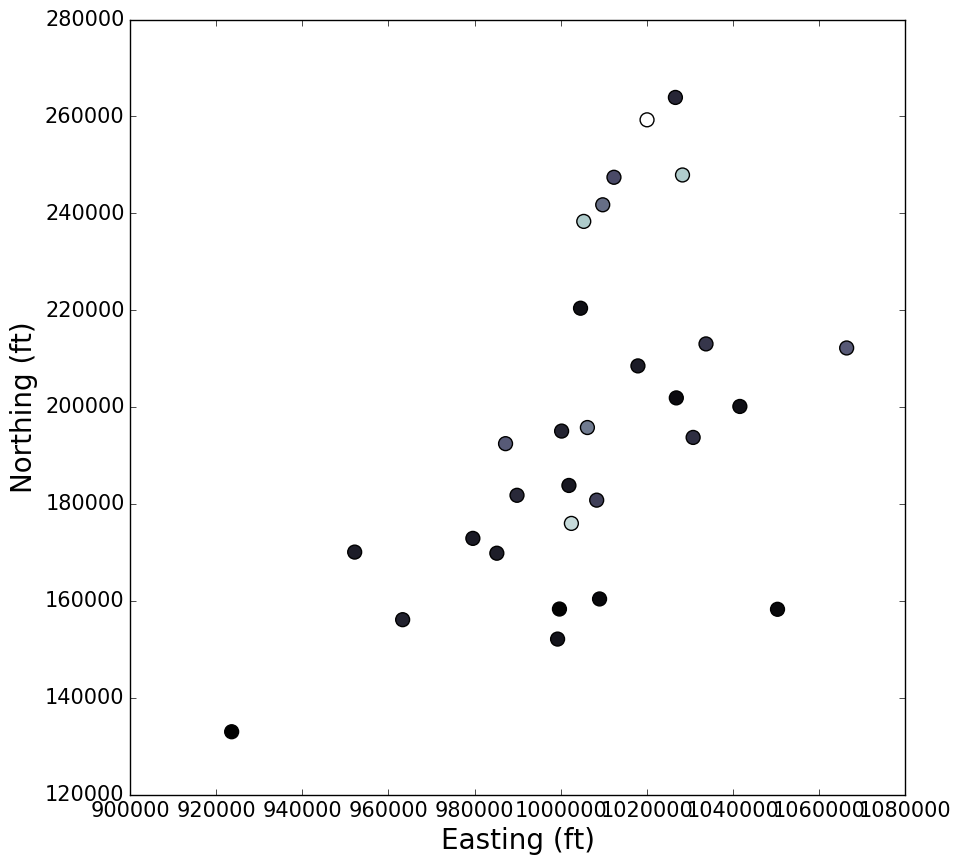

In [42]:
pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (ft)", fontsize=20)
pl.ylabel("Northing (ft)", fontsize=20)

The plot above shows the locations of the centroid of each NYC zipcode (in the nycasthmasdismissals table) with each points' color representing the number of asthma dismissals for a given zipcode. The darker, the higher the count.

In [13]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    #distance matrix (eucledian)
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N

    Z = list()
    for i in range(N):
        for j in range(i+1, N):
            #select only pair of points at the appropriate lag
            if( pdsv[i,j] >= h - bw )and( pdsv[i,j] <= h + bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    #print Z
    return np.sum( Z ) / ( 2.0 * len( Z ) )


def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        sv.append( SVh( P, h, bw ) )
        #sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T



In [38]:
print  SVh_vctzd( krigdata, 100000, 10000 )

526493.987179


In [40]:
lag = 10000
mysv = SV( krigdata, np.arange(1, 100000, lag) , 100000)
print mysv

[[  1.00000000e+00   1.00010000e+04   2.00010000e+04   3.00010000e+04
    4.00010000e+04   5.00010000e+04   6.00010000e+04   7.00010000e+04
    8.00010000e+04   9.00010000e+04]
 [  2.74988067e+05   2.87441297e+05   2.92363964e+05   2.88611542e+05
    2.90145414e+05   2.89993720e+05   2.96591866e+05   2.96032007e+05
    2.96032007e+05   2.96032007e+05]]


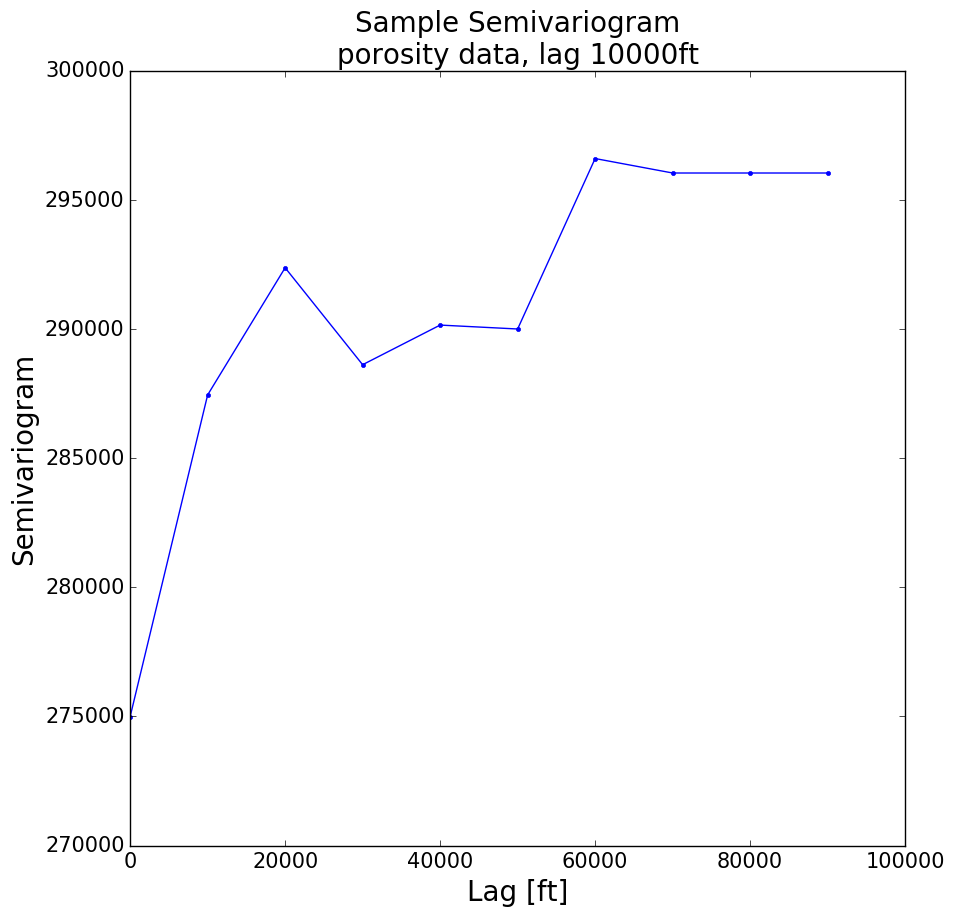

In [41]:
#mysv = SV( x, hs, bw )
pl.figure(figsize=(10,10))
plot( mysv[0], mysv[1], '.-' )
pl.xlabel('Lag [ft]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Sample Semivariogram\nporosity data, lag %dft'%lag, fontsize=20)

The data is most similar to one another with around a 60,000 ft radius (just over 10 miles). There is also a spike around 20,000 ft (about 4 miles), meaning that asthma zipcodes are relatively similar to other zipcodes within a 4 mile radius, but less so in an 8 mile radius.

In [ ]:
#@Review:
#comment on what's happening, what you infer? See solution.